In [14]:
def is_interactive():
    return "runtime" in get_ipython().config.IPKernelApp.connection_file

print("is_interactive", is_interactive())

is_interactive True


In [15]:
%config InlineBackend.figure_format = "png"
%config InlineBackend.print_figure_kwargs = {'dpi': 600}

In [16]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl

from src.preprocess import process_label


plt.style.use("tableau-colorblind10")

In [17]:
data_dir = Path("/ml-docker/input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))

[PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/test_eegs'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/test.csv'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/example_figures'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/test_spectrograms'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/train_spectrograms'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/sample_submission.csv'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/train_eegs'),
 PosixPath('/ml-docker/input/hms-harmful-brain-activity-classification/train.csv')]

In [18]:
metadata = pl.read_csv(data_dir / "train.csv")

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike


def format_time(x, pos):
    sgn = "-" if x < 0 else ""
    total_seconds = int(abs(x))
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{sgn}{hours:02d}:{minutes:02d}:{seconds:02d}"


def format_min(x, pos):
    sgn = "-" if x < 0 else ""
    total_seconds = int(abs(x))
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{sgn}{minutes:02d}:{seconds:02d}"


def shift_plot(
    ys: list[ArrayLike],
    shift: float,
    names: list[str],
    x: ArrayLike | None = None,
    ax=None,
    area=False,
    colors=None,
    **kwargs,
):
    if ax is None:
        fig, ax = plt.subplots()

    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, (name, y) in enumerate(zip(names, ys)):
        if type(y) is not np.ndarray:
            y = np.asarray(y)

        offset = i * -shift
        if area:
            if x is None:
                x = np.arange(len(y))
            ax.fill_between(
                x, y1=y + offset, y2=offset, label=name, color=colors[i], **kwargs
            )
        else:
            args = [y + offset]
            if x is not None:
                args = [x, *args]
            ax.plot(*args, label=name, color=colors[i], **kwargs)

    num_ticks = len(names)
    y_ticks = np.linspace(0, -shift * num_ticks, num_ticks, endpoint=False)
    #ax.set_yticks(ticks=y_ticks, labels=names)
    ax.set_yticks([])

    return ax


In [20]:
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS, PROBE2IDX, PROBE_GROUPS
from src.plot_util import format_time, shift_plot
from src.preprocess import (
    do_apply_filter,
    load_eeg,
    load_spectrogram,
    map_log_scale,
    process_eeg,
)


def mean_std_normalization(x, axis=None, eps=1e-5):
    x_mean = np.mean(x, axis=axis, keepdims=True)
    x_std = np.std(x, axis=axis, keepdims=True)
    return (x - x_mean) / (x_std + eps)


def mean_normalization(x, axis=None):
    x_mean = np.mean(x, axis=axis, keepdims=True)
    return x - x_mean


def normalize_for_image(x, axis=None):
    x_min = np.min(x, axis=axis, keepdims=True)
    x_max = np.max(x, axis=axis, keepdims=True)
    return (x - x_min) / (x_max - x_min) * 255


def plot_eeg(
    x: np.ndarray,
    mask: np.ndarray | None = None,
    offset_sec: float = 0,
    time_zoom: float = 1.0,
    sampling_rate: int = 200,
    duration_sec: int = 50,
    shift: float = 0.1,
    ax=None,
    lw: float = 0.8,
    display_all_series=True,
    down_sampling_rate=5,
    apply_filter=True,
    cutoff_freqs=(0.5, 50),
    clip_val: float = 1000,
):
    x = x.copy()
    if down_sampling_rate > 1:
        sampling_rate = sampling_rate // down_sampling_rate

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 12))
    names = []

    center_sec = offset_sec + duration_sec / 2
    window_sec = (duration_sec / 2) / time_zoom
    time_start_sec = center_sec - window_sec
    time_end_sec = center_sec + window_sec
    total_sec = x.shape[0] / sampling_rate

    num_samples = x.shape[0]
    time = np.linspace(0, total_sec, num_samples)
    probe_groups = dict()
    for group in ["LL", "RL", "LP", "RP", "Z"]:
        probe_groups[group] = PROBE_GROUPS[group]

    group2color = dict(LL="C0", RL="C1", LP="C0", RP="C1", Z="C2")

    signals = []
    names = []
    masks = []
    colors = []
    for i, (probe_group, probes) in enumerate(probe_groups.items()):
        color = group2color[probe_group]
        for p1, p2 in zip(probes[:-1], probes[1:]):
            name = f"{p1}-{p2}" if p2 is not None else p1
            voltage = (
                x[..., PROBE2IDX[p1]] - x[..., PROBE2IDX[p2]]
                if p2 is not None
                else x[:, PROBE2IDX[p1]]
            )
            voltage = np.clip(voltage, -clip_val, clip_val)
            if mask is not None:
                voltage *= mask[..., PROBE2IDX[p1]] * mask[..., PROBE2IDX[p2]]
                masks.append(mask[..., PROBE2IDX[p1]] * mask[..., PROBE2IDX[p2]])
            if name == "EKG":
                voltage = mean_std_normalization(voltage) * shift / 10
            else:
                voltage = mean_normalization(voltage)

            signals.append(voltage)
            names.append(name)
            colors.append(color)

    signals = np.stack(signals, axis=0)
    if apply_filter:
        signals = do_apply_filter(signals, sampling_rate, cutoff_freqs)
    sig = []
    for i in range(signals.shape[0]):
        sig.append(signals[i])

    names.append("EKG")
    sig.append(x[:, PROBE2IDX["EKG"]] / 10)
    colors.append("red")

    shift_plot(sig, shift, names, x=time, ax=ax, area=False, alpha=0.5, colors=colors)

    num_ticks = len(names)
    y_min, y_max = -shift * num_ticks, 0
    y_ticks = np.linspace(y_max, y_min, num_ticks, endpoint=False)

    y_lim = (y_min - shift, y_max + 2 * shift)
    # ax.set_yticks(ticks=y_ticks, labels=names)
    ax.set_yticks([])
    ax.vlines(
        center_sec,
        *y_lim,
        color="gray",
        linewidth=lw,
        linestyles="dashed",
    )
    ax.vlines(time_start_sec, *y_lim, color="gray", linewidth=lw)
    ax.vlines(time_end_sec, *y_lim, color="gray", linewidth=lw)
    ax.axvspan(
        time_start_sec,
        time_end_sec,
        alpha=0.5,
        color="white",
    )
    if not display_all_series:
        ax.set_xlim(time_start_sec, time_end_sec)

    formatter = ticker.FuncFormatter(format_time)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylim(y_min - shift, y_max + 2 * shift)
    return ax


def plot_spectrogram(
    spectrogram: pl.DataFrame,
    offset_sec: float = 0,
    fig=None,
    axes=None,
    sampling_rate: float = 0.5,
    duration_sec: int = 600,
    eeg_duration_sec: int = 50,
    display_all_series=False,
):
    formatter = ticker.FuncFormatter(format_time)
    freqs = [float(col[3:]) for col in spectrogram.columns[1:101]][::-1]

    x = map_log_scale(spectrogram.drop("time").fill_null(0).to_numpy())
    num_samples = x.shape[0]
    if display_all_series:
        total_frame_sec = num_samples / sampling_rate
    else:
        x = x[
            int(offset_sec * sampling_rate) : int(
                (offset_sec + duration_sec) * sampling_rate
            )
        ]
        offset_sec = 0
        total_frame_sec = duration_sec

    x_ll = x[:, :100]
    x_rl = x[:, 100:200]
    x_lp = x[:, 200:300]
    x_rp = x[:, 300:400]

    time = np.linspace(0, total_frame_sec, num_samples)
    center_sec = offset_sec + duration_sec / 2

    extent = (time[0], time[-1], freqs[0], freqs[-1])

    categories = ["LL", "RL", "LP", "RP"]
    if axes is None:
        fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    plt.subplots_adjust(hspace=0.05)
    for ax, x, category in zip(axes, [x_ll, x_rl, x_lp, x_rp], categories):
        #ax.xaxis.set_major_formatter(formatter)
        cax = ax.imshow(x.T, aspect="auto", cmap="jet", extent=extent, vmin=-40, vmax=0)
        # fig.colorbar(cax, ax=ax)  # type: ignore
        # ax.set(ylabel="Freq[Hz]", xlim=(time[0], time[-1]))
        ax.invert_yaxis()
        ax.text(
            -0.06,
            0.94,
            category,
            transform=ax.transAxes,
            ha="left",
            va="bottom",
            size=12,
        )
        ax.vlines(
            center_sec,
            freqs[0],
            freqs[-1],
            color="white",
            linewidth=1,
            linestyles="dashed",
        )
        ax.vlines(
            offset_sec,
            freqs[0],
            freqs[-1],
            color="white",
            linewidth=1,
        )
        ax.vlines(
            offset_sec + duration_sec,
            freqs[0],
            freqs[-1],
            color="white",
            linewidth=1,
        )
        if display_all_series:
            ax.axvspan(offset_sec, offset_sec + duration_sec, alpha=0.5, color="white")
        else:
            ax.axvspan(
                center_sec - eeg_duration_sec / 2,
                center_sec + eeg_duration_sec / 2,
                alpha=0.5,
                color="white",
            )


def plot_data(
    metadata: pl.DataFrame,
    eeg_id: int,
    eeg_sub_id: int,
    data_dir: Path = Path("/kaggle/input/hms-harmful-brain-activity-classification"),
    phase: str = "train",
    apply_filter: bool = True,
    cutoff_freqs: tuple[float, float] = (0.5, 50),
    ref_voltage: float = 1000,
    force_zero_padding: bool = False,
):
    row = metadata.filter(
        pl.col("eeg_id").eq(eeg_id).and_(pl.col("eeg_sub_id").eq(eeg_sub_id))
    )
    eeg_id, spectrogram_id = row["eeg_id"][0], row["spectrogram_id"][0]
    label_id = row["label_id"][0]
    vote_columns = [f"{label}_vote" for label in LABELS]
    label2vote = (
        row.select(vote_columns)
        .rename({k: v for k, v in zip(vote_columns, LABELS)})
        .to_pandas()
        .T[0]
        .to_dict()
    )

    vote_tags = []
    for label, vote in sorted(label2vote.items(), key=lambda x: x[1], reverse=True):
        if vote > 0:
            vote_tags.append(f"{vote} {label.upper()}")

    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(4, 2, width_ratios=(2, 3), hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax5 = fig.add_subplot(gs[:, 1])

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)

    eeg_df = load_eeg(eeg_id, data_dir, phase=phase)
    eeg, pad_mask = process_eeg(eeg_df)
    if force_zero_padding:
        eeg *= pad_mask[:, np.newaxis]
    eeg /= ref_voltage

    spectrogram = load_spectrogram(spectrogram_id, data_dir, phase=phase)

    spectrogram_offset_sec = row["spectrogram_label_offset_seconds"][0]
    eeg_offset_sec = row["eeg_label_offset_seconds"][0]
    plot_spectrogram(
        spectrogram,
        fig=fig,
        axes=[ax1, ax2, ax3, ax4],
        duration_sec=600,
        offset_sec=spectrogram_offset_sec,
    )
    plot_eeg(
        eeg,
        ax=ax5,
        duration_sec=50,
        offset_sec=eeg_offset_sec,
        display_all_series=False,
        apply_filter=apply_filter,
        cutoff_freqs=cutoff_freqs,
    )

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set(xlabel=None, ylabel=None)
        ax.margins(x=0, y=0)

    plt.tight_layout()
    plt.gca().margins(x=0, y=0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

In [21]:
metadata_per_eeg = process_label(metadata).filter(pl.col("eeg_sub_id").eq(0)).filter(pl.col("weight").ge(0.3))
metadata_per_eeg.shape

(5441, 54)

In [22]:
NUM_SAMPLES = len(metadata_per_eeg) // 100

if is_interactive():
    eeg_ids = metadata_per_eeg.get_column("eeg_id").sample(NUM_SAMPLES).to_numpy()
else:
    eeg_ids = metadata_per_eeg.get_column("eeg_id").to_numpy()

In [23]:
from tqdm import tqdm

img_dir = Path("/ml-docker/working/kaggle-hms-bilzard/data/annotator_image/image")
if not img_dir.exists():
    img_dir.mkdir(parents=True, exist_ok=True)

for eeg_id in tqdm(eeg_ids):
    plot_data(metadata_per_eeg, eeg_id, eeg_sub_id=0, data_dir=data_dir)
    canvas = plt.gcf().canvas
    canvas.draw()
    img = np.array(canvas.renderer.buffer_rgba())
    np.save(f"{img_dir}/{eeg_id}.npy", img)
    plt.close()

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:13<00:00,  4.07it/s]


In [30]:
%config InlineBackend.figure_format = "jpg"
%config InlineBackend.print_figure_kwargs = {'dpi': 96}

(800, 1600, 4)


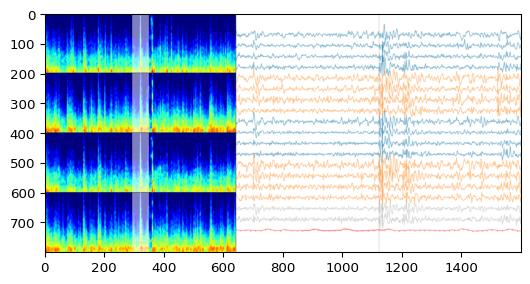

(800, 1600, 4)


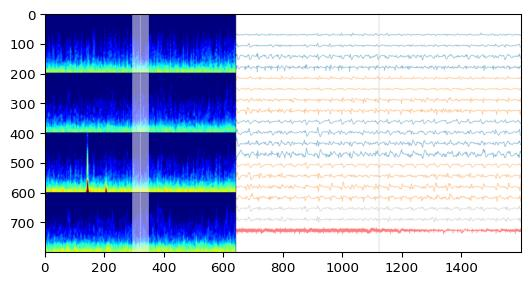

(800, 1600, 4)


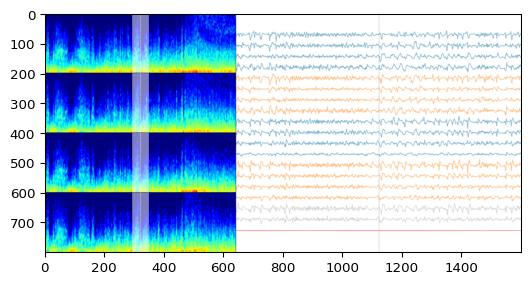

In [31]:
for path in list(img_dir.glob("*"))[:3]:
    image = np.load(path)
    print(image.shape)
    plt.imshow(image)
    plt.show()